In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Ignore warnings
import warnings
warnings.simplefilter("ignore", UserWarning)

# Import packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50V2, EfficientNetV2B0
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
import torch
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms

from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split

In [3]:
train_data_dir = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train'
test_data_dir = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test'

# Set image size
image_height, image_width = 32, 32

# Load training data
train_data = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    batch_size=128,
    shuffle=True,
    image_size=(image_height, image_width)
)

# Load validation data
validation_data = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    batch_size=128,
    image_size=(image_height, image_width)
)

# Load test data
test_data = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    seed=123,
    batch_size=128,
    image_size=(image_height, image_width)
)

# Print class names of data
class_names = train_data.class_names
print("\nData consists of " + str(len(class_names)) + " classes:", class_names)

Found 100000 files belonging to 2 classes.
Using 80000 files for training.
Found 100000 files belonging to 2 classes.
Using 20000 files for validation.
Found 20000 files belonging to 2 classes.

Data consists of 2 classes: ['FAKE', 'REAL']


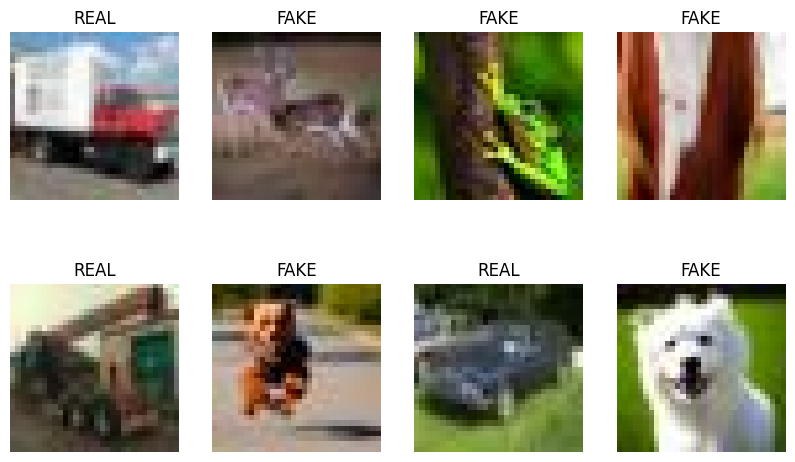

In [4]:
# Plot sample of training data
plt.figure(figsize=(10, 6))
for images, labels in train_data.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [5]:
# Configure dataset for increased performance during training
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.prefetch(buffer_size=AUTOTUNE)
validation_data = validation_data.prefetch(buffer_size=AUTOTUNE)

In [6]:
# Create a simple CNN architecture
model = tf.keras.Sequential([
    layers.Resizing(image_height, image_width),
    layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[BinaryAccuracy(name='Accuracy'), Precision(name='Precision'), Recall(name='Recall')]
)

# Build the model and show the summary
model.build(input_shape=(None, image_height, image_width, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 3)         0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 7200)              0         
                                                                 
 dense (Dense)               (None, 64)                460864    
                                                        

In [7]:
# Set number of epochs
num_epochs = 20

# Train the model
history = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=num_epochs
)

Epoch 1/20
625/625 [==============================] - 69s 104ms/step - loss: 0.4210 - Accuracy: 0.8054 - Precision: 0.8035 - Recall: 0.8087 - val_loss: 0.3513 - val_Accuracy: 0.8502 - val_Precision: 0.8214 - val_Recall: 0.8947
Epoch 2/20
625/625 [==============================] - 21s 34ms/step - loss: 0.3190 - Accuracy: 0.8656 - Precision: 0.8605 - Recall: 0.8728 - val_loss: 0.2978 - val_Accuracy: 0.8806 - val_Precision: 0.8556 - val_Recall: 0.9156
Epoch 3/20
625/625 [==============================] - 20s 32ms/step - loss: 0.2820 - Accuracy: 0.8854 - Precision: 0.8809 - Recall: 0.8913 - val_loss: 0.2756 - val_Accuracy: 0.8902 - val_Precision: 0.8620 - val_Recall: 0.9290
Epoch 4/20
625/625 [==============================] - 22s 36ms/step - loss: 0.2556 - Accuracy: 0.8972 - Precision: 0.8935 - Recall: 0.9019 - val_loss: 0.2537 - val_Accuracy: 0.9014 - val_Precision: 0.9008 - val_Recall: 0.9019
Epoch 5/20
625/625 [==============================] - 20s 32ms/step - loss: 0.2412 - Accuracy: 

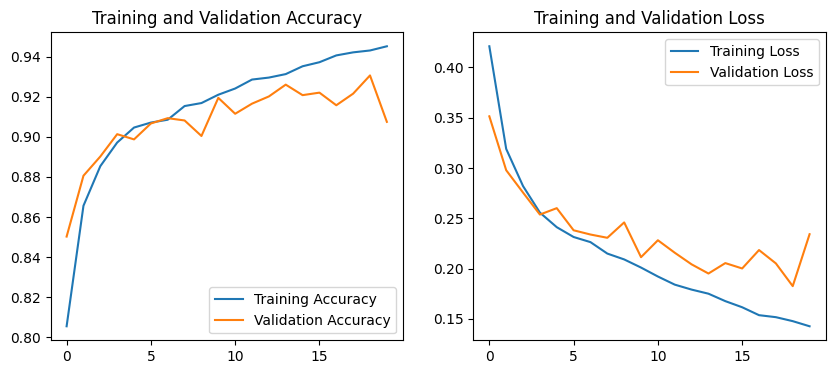

In [8]:
# Get training and validation accuracy
acc = history.history['Accuracy']
val_acc = history.history['val_Accuracy']

# Get training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

# Visualize accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), acc, label='Training Accuracy')
plt.plot(range(num_epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Visualize loss
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), loss, label='Training Loss')
plt.plot(range(num_epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [9]:
# Evaluate the model on the test data
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_data)

print(f'\nAccuracy on test data: {test_accuracy}')
print(f'\nPrecision on test data: {test_precision}')
print(f'\nRecall on test data: {test_recall}')

157/157 [==============================] - 18s 107ms/step - loss: 0.2271 - Accuracy: 0.9071 - Precision: 0.8593 - Recall: 0.9737

Accuracy on test data: 0.9071499705314636

Precision on test data: 0.8593239784240723

Recall on test data: 0.9736999869346619


157/157 [==============================] - 5s 32ms/step


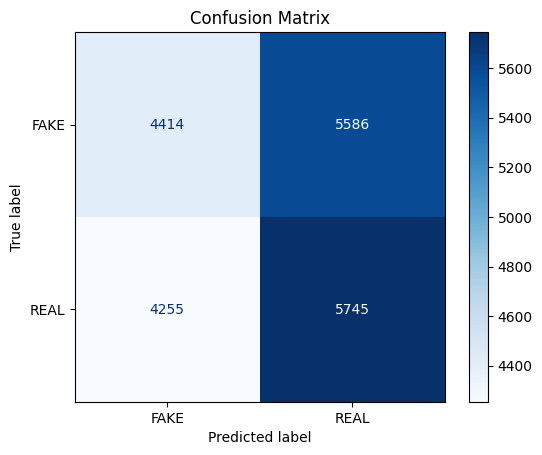

In [10]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay


# Predict probabilities on the test set
y_pred_probs = model.predict(test_data)
y_true = np.concatenate([y for _, y in test_data])

# Convert probabilities to binary predictions
y_pred = (y_pred_probs > 0.5).astype(int)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

<Figure size 800x600 with 0 Axes>

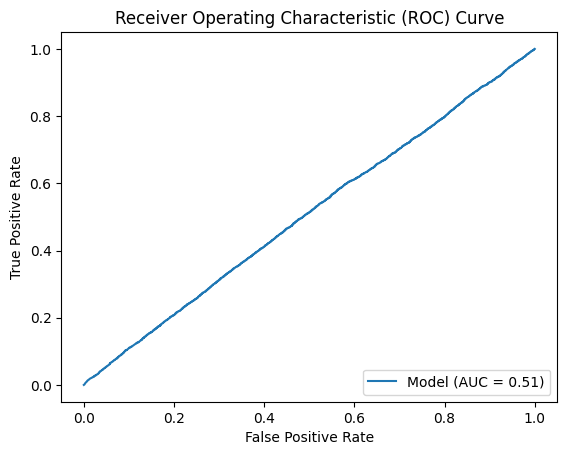

In [11]:
# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Model').plot()
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

**Fintuning on ResNet50V2**

In [12]:
# Load the ResNet50V2 model pre-trained on ImageNet data
base_model = ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape=(image_height, image_width, 3),
    pooling='max'
)

# Make the pre-trained model trainable for finetuning
base_model.trainable = True

# Create a custom model on top of ResNet50V2
model = tf.keras.Sequential([
    base_model,
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer=Adamax(learning_rate=0.001), 
    loss='binary_crossentropy', 
    metrics=[BinaryAccuracy(name='Accuracy'), Precision(name='Precision'), Recall(name='Recall')]
)

# Build the model and show the summary
model.build(input_shape=(None, image_height, image_width, 3))
model.summary()

94668760/94668760 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 24089601 (91.89 MB)
Trainable params: 24044161 (91.72 MB)
Non-trainable params: 45440 (177.50 KB)
_________________________________________________________________


In [13]:
# Set scheduler to decrease learning rate after 5 epochs
def scheduler(epoch, lr):
    if epoch <= 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
callback_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Set number of epochs
num_epochs=20

# Train the model
history = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=num_epochs,
    callbacks=[callback_scheduler]
)

Epoch 1/20
625/625 [==============================] - 70s 64ms/step - loss: 0.2919 - Accuracy: 0.8791 - Precision: 0.8767 - Recall: 0.8825 - val_loss: 0.1711 - val_Accuracy: 0.9348 - val_Precision: 0.9324 - val_Recall: 0.9375 - lr: 0.0010
Epoch 2/20
625/625 [==============================] - 39s 62ms/step - loss: 0.1484 - Accuracy: 0.9439 - Precision: 0.9403 - Recall: 0.9480 - val_loss: 0.2615 - val_Accuracy: 0.9111 - val_Precision: 0.9726 - val_Recall: 0.8460 - lr: 0.0010
Epoch 3/20
625/625 [==============================] - 39s 61ms/step - loss: 0.1129 - Accuracy: 0.9572 - Precision: 0.9555 - Recall: 0.9591 - val_loss: 0.2109 - val_Accuracy: 0.9327 - val_Precision: 0.9658 - val_Recall: 0.8972 - lr: 0.0010
Epoch 4/20
625/625 [==============================] - 39s 61ms/step - loss: 0.0935 - Accuracy: 0.9650 - Precision: 0.9647 - Recall: 0.9653 - val_loss: 0.1612 - val_Accuracy: 0.9482 - val_Precision: 0.9582 - val_Recall: 0.9374 - lr: 0.0010
Epoch 5/20
625/625 [========================

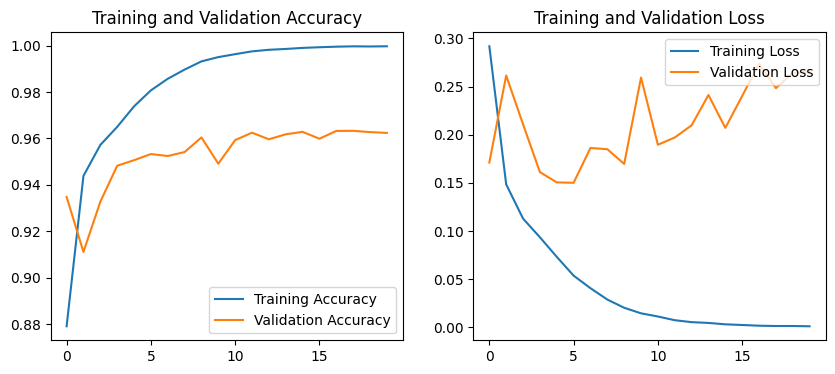

In [14]:
# Get training and validation accuracy
acc = history.history['Accuracy']
val_acc = history.history['val_Accuracy']

# Get training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

# Visualize accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), acc, label='Training Accuracy')
plt.plot(range(num_epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Visualize loss
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), loss, label='Training Loss')
plt.plot(range(num_epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
# Evaluate the model on the test data
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_data)

print(f'\nAccuracy on test data: {test_accuracy}')
print(f'\nPrecision on test data: {test_precision}')
print(f'\nRecall on test data: {test_recall}')


157/157 [==============================] - 9s 54ms/step - loss: 0.2617 - Accuracy: 0.9625 - Precision: 0.9550 - Recall: 0.9709

Accuracy on test data: 0.9625499844551086

Precision on test data: 0.9549522995948792

Recall on test data: 0.9708999991416931


157/157 [==============================] - 6s 28ms/step


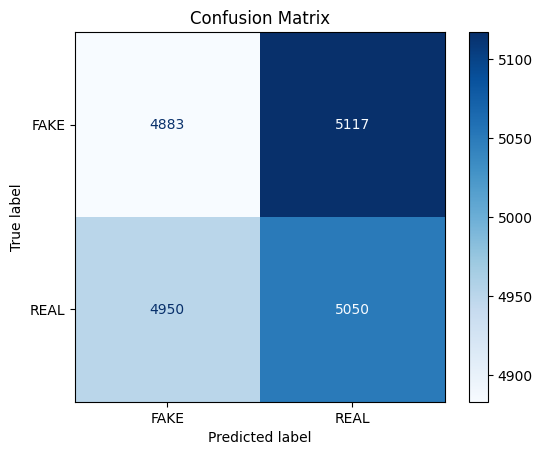

In [16]:
# Predict probabilities on the test set
y_pred_probs = model.predict(test_data)
y_true = np.concatenate([y for _, y in test_data])

# Convert probabilities to binary predictions
y_pred = (y_pred_probs > 0.5).astype(int)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

<Figure size 800x600 with 0 Axes>

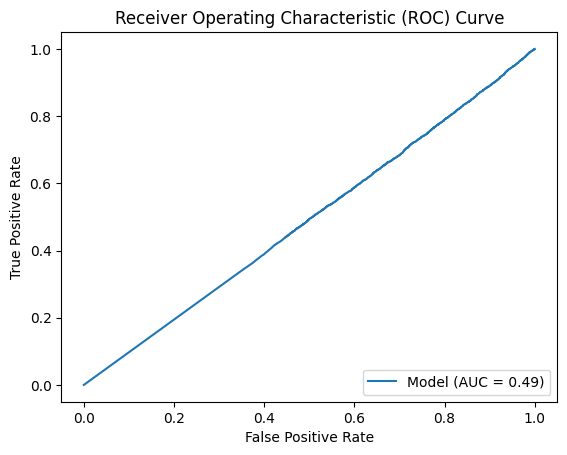

In [17]:
# AUC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot AUC Curve
plt.figure(figsize=(8, 6))
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Model').plot()
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

Finetune EfficientNetV2B0

In [18]:
# Load the EfficientNetV2B0 model pre-trained on ImageNet data
base_model = EfficientNetV2B0(
    weights='imagenet',
    include_top=False,
    input_shape=(image_height, image_width, 3),
    pooling='max'
)

# Make the pre-trained model trainable for finetuning
base_model.trainable = True

# Create a custom model on top of EfficientNetV2B0
model = tf.keras.Sequential([
    base_model,
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer=Adamax(learning_rate=0.001), 
    loss='binary_crossentropy', 
    metrics=[BinaryAccuracy(name='Accuracy'), Precision(name='Precision'), Recall(name='Recall')]
)

# Build the model and show the summary
model.build(input_shape=(None, image_height, image_width, 3))
model.summary()

24274472/24274472 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Functio  (None, 1280)              5919312   
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 256)               327936    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 6247505 (23.83 MB)
Trainable params: 6186897 (23.60 MB)
Non-trainable params: 60608 (236.75 KB)
_________________________________________________________________


In [19]:
# Set scheduler to decrease learning rate after 5 epochs
def scheduler(epoch, lr):
    if epoch <= 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
callback_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Set number of epochs
num_epochs=20

# Train the model
history = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=num_epochs,
    callbacks=[callback_scheduler]
)

Epoch 1/20


2024-01-29 18:15:29.738589: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/efficientnetv2-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


625/625 [==============================] - 81s 65ms/step - loss: 0.2109 - Accuracy: 0.9139 - Precision: 0.9163 - Recall: 0.9111 - val_loss: 0.1141 - val_Accuracy: 0.9571 - val_Precision: 0.9579 - val_Recall: 0.9562 - lr: 0.0010
Epoch 2/20
625/625 [==============================] - 38s 60ms/step - loss: 0.1025 - Accuracy: 0.9614 - Precision: 0.9629 - Recall: 0.9599 - val_loss: 0.0950 - val_Accuracy: 0.9656 - val_Precision: 0.9622 - val_Recall: 0.9691 - lr: 0.0010
Epoch 3/20
625/625 [==============================] - 37s 59ms/step - loss: 0.0692 - Accuracy: 0.9740 - Precision: 0.9753 - Recall: 0.9726 - val_loss: 0.0909 - val_Accuracy: 0.9689 - val_Precision: 0.9728 - val_Recall: 0.9649 - lr: 0.0010
Epoch 4/20
625/625 [==============================] - 37s 59ms/step - loss: 0.0481 - Accuracy: 0.9819 - Precision: 0.9826 - Recall: 0.9810 - val_loss: 0.0974 - val_Accuracy: 0.9701 - val_Precision: 0.9725 - val_Recall: 0.9675 - lr: 0.0010
Epoch 5/20
625/625 [==============================] - 3

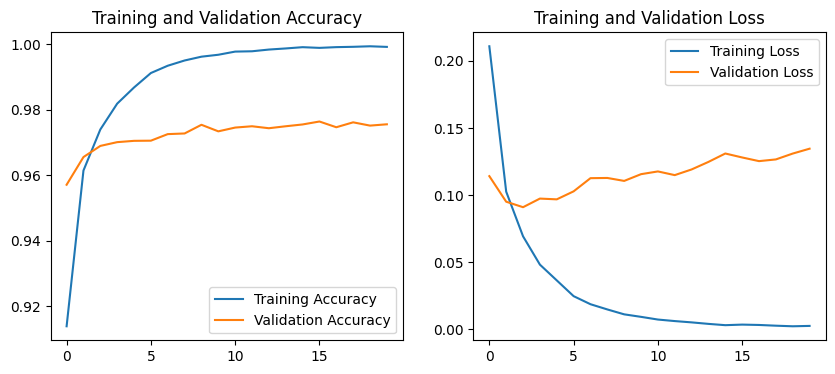

In [20]:
# Get training and validation accuracy
acc = history.history['Accuracy']
val_acc = history.history['val_Accuracy']

# Get training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

# Visualize accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), acc, label='Training Accuracy')
plt.plot(range(num_epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Visualize loss
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), loss, label='Training Loss')
plt.plot(range(num_epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
# Evaluate the model on the test data
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_data)

print(f'\nAccuracy on test data: {test_accuracy}')
print(f'\nPrecision on test data: {test_precision}')
print(f'\nRecall on test data: {test_recall}')

157/157 [==============================] - 8s 48ms/step - loss: 0.1426 - Accuracy: 0.9751 - Precision: 0.9714 - Recall: 0.9790

Accuracy on test data: 0.9750999808311462

Precision on test data: 0.9714229106903076

Recall on test data: 0.9789999723434448


157/157 [==============================] - 6s 24ms/step


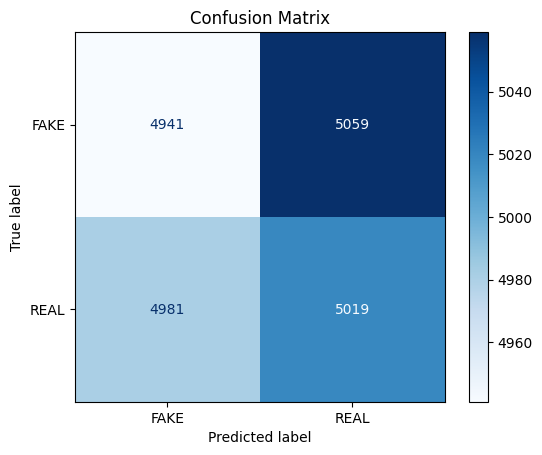

In [22]:
# Predict probabilities on the test set
y_pred_probs = model.predict(test_data)
y_true = np.concatenate([y for _, y in test_data])

# Convert probabilities to binary predictions
y_pred = (y_pred_probs > 0.5).astype(int)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

<Figure size 800x600 with 0 Axes>

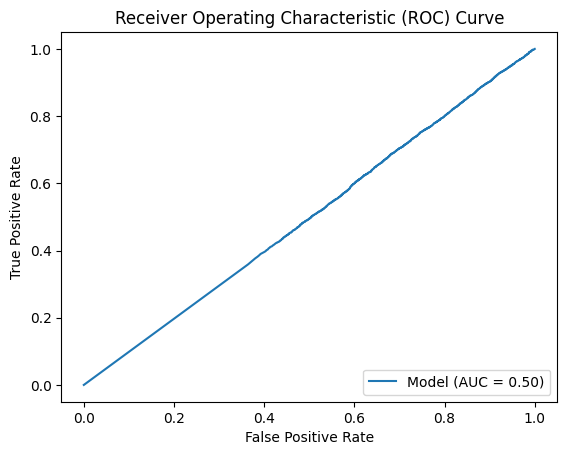

In [23]:
# AUC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot AUC Curve
plt.figure(figsize=(8, 6))
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Model').plot()
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

In [24]:
from tensorflow.keras.applications import EfficientNetB7

# Load the EfficientNetB7 model pre-trained on ImageNet data
base_model_b7 = EfficientNetB7(
    weights='imagenet',
    include_top=False,
    input_shape=(image_height, image_width, 3),
    pooling='max'
)

# Make the pre-trained model trainable for fine-tuning
base_model_b7.trainable = True

# Create a custom model on top of EfficientNetB7
model_b7 = tf.keras.Sequential([
    base_model_b7,
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_b7.compile(
    optimizer=Adamax(learning_rate=0.001), 
    loss='binary_crossentropy', 
    metrics=[BinaryAccuracy(name='Accuracy'), Precision(name='Precision'), Recall(name='Recall')]
)

# Build the model and show the summary
model_b7.build(input_shape=(None, image_height, image_width, 3))
model_b7.summary()

258076736/258076736 [==============================] - 2s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 2560)              64097687  
 )                                                               
                                                                 
 dense_6 (Dense)             (None, 256)               655616    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 64753560 (247.02 MB)
Trainable params: 64442833 (245.83 MB)
Non-trainable params: 310727 (1.19 MB)
_________________________________________________________________


In [25]:
# Set scheduler to decrease learning rate after 5 epochs
def scheduler(epoch, lr):
    if epoch <= 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
callback_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Set number of epochs
num_epochs = 25

# Train the model
history_b7 = model_b7.fit(
    train_data,
    validation_data=validation_data,
    epochs=num_epochs,
    callbacks=[callback_scheduler]
)

Epoch 1/25


2024-01-29 18:29:58.889841: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/efficientnetb7/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


625/625 [==============================] - 239s 192ms/step - loss: 0.2088 - Accuracy: 0.9130 - Precision: 0.9133 - Recall: 0.9126 - val_loss: 0.1026 - val_Accuracy: 0.9614 - val_Precision: 0.9571 - val_Recall: 0.9661 - lr: 0.0010
Epoch 2/25
625/625 [==============================] - 114s 182ms/step - loss: 0.0805 - Accuracy: 0.9698 - Precision: 0.9706 - Recall: 0.9689 - val_loss: 0.1065 - val_Accuracy: 0.9639 - val_Precision: 0.9478 - val_Recall: 0.9820 - lr: 0.0010
Epoch 3/25
625/625 [==============================] - 114s 182ms/step - loss: 0.0483 - Accuracy: 0.9822 - Precision: 0.9818 - Recall: 0.9827 - val_loss: 0.1085 - val_Accuracy: 0.9694 - val_Precision: 0.9810 - val_Recall: 0.9573 - lr: 0.0010
Epoch 4/25
625/625 [==============================] - 114s 182ms/step - loss: 0.0275 - Accuracy: 0.9901 - Precision: 0.9906 - Recall: 0.9897 - val_loss: 0.0969 - val_Accuracy: 0.9736 - val_Precision: 0.9685 - val_Recall: 0.9791 - lr: 0.0010
Epoch 5/25
625/625 [===========================

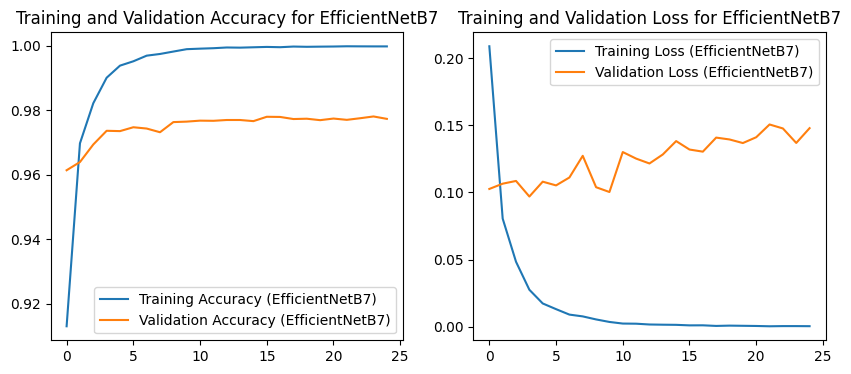

In [26]:
# Get training and validation accuracy for EfficientNetB7
acc_b7 = history_b7.history['Accuracy']
val_acc_b7 = history_b7.history['val_Accuracy']

# Get training and validation loss for EfficientNetB7
loss_b7 = history_b7.history['loss']
val_loss_b7 = history_b7.history['val_loss']

# Visualize accuracy for EfficientNetB7
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), acc_b7, label='Training Accuracy (EfficientNetB7)')
plt.plot(range(num_epochs), val_acc_b7, label='Validation Accuracy (EfficientNetB7)')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy for EfficientNetB7')

# Visualize loss for EfficientNetB7
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), loss_b7, label='Training Loss (EfficientNetB7)')
plt.plot(range(num_epochs), val_loss_b7, label='Validation Loss (EfficientNetB7)')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss for EfficientNetB7')
plt.show()

In [27]:
# Evaluate the model on the test data
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_data)

print(f'\nAccuracy on test data: {test_accuracy}')
print(f'\nPrecision on test data: {test_precision}')
print(f'\nRecall on test data: {test_recall}')

157/157 [==============================] - 8s 51ms/step - loss: 0.1426 - Accuracy: 0.9751 - Precision: 0.9714 - Recall: 0.9790

Accuracy on test data: 0.9750999808311462

Precision on test data: 0.9714229106903076

Recall on test data: 0.9789999723434448


157/157 [==============================] - 4s 25ms/step


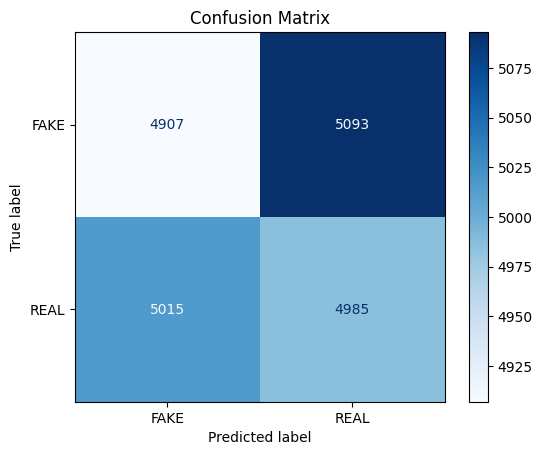

In [28]:
# Predict probabilities on the test set
y_pred_probs = model.predict(test_data)
y_true = np.concatenate([y for _, y in test_data])

# Convert probabilities to binary predictions
y_pred = (y_pred_probs > 0.5).astype(int)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

<Figure size 800x600 with 0 Axes>

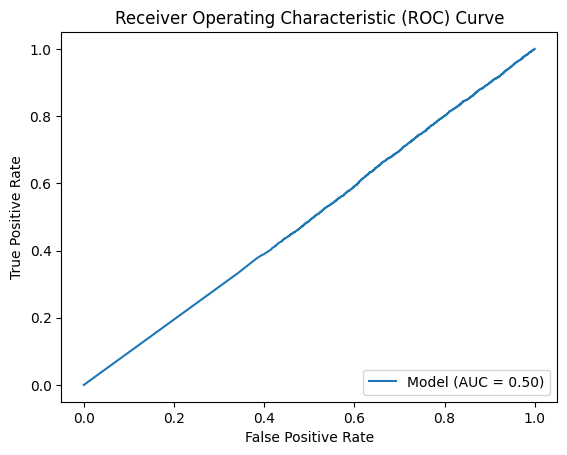

In [30]:
# AUC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot AUC Curve
plt.figure(figsize=(8, 6))
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Model').plot()
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()